<a href="https://colab.research.google.com/github/fariyanalam/Projects/blob/main/Simulating_Gravitational_Lensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

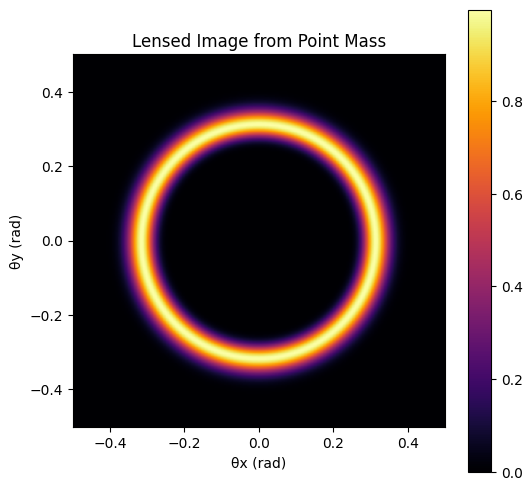

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

G = 1
c = 1
Distance_source = 1.0
Distance_lens = 0.5
Distance_ls = Distance_source - Distance_lens

def deflection_angle(theta_x, theta_y, M):
    r_squared = theta_x**2 + theta_y**2 + 1e-8
    alpha_x = 4 * G * M / c**2 * theta_x / r_squared
    alpha_y = 4 * G * M / c**2 * theta_y / r_squared
    return alpha_x, alpha_y

def gaussian_source(x, y, x0 = 0, y0 = 0, sigma=0.05):
    return np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

npix = 256
fov = 1.0

x = np.linspace(-fov/2, fov/2, npix)
y = np.linspace(-fov/2, fov/2, npix)
theta_x, theta_y = np.meshgrid(x, y)

M = 0.05

alpha_x, alpha_y = deflection_angle(theta_x, theta_y, M)

beta_x = theta_x - (Distance_ls / Distance_source) * alpha_x
beta_y = theta_y - (Distance_ls / Distance_source) * alpha_y

source_x = x
source_y = y
source_grid_x, source_grid_y = np.meshgrid(source_x, source_y)

source_plane = gaussian_source(source_grid_x, source_grid_y, x0 = 0.0, y0 = 0.0)

scale = npix / fov
coords_x = (beta_x + fov / 2) * scale
coords_y = (beta_y + fov / 2) * scale
coords = np.array([coords_y.flatten(), coords_x.flatten()])

lensed_image = map_coordinates(source_plane, coords, order = 1).reshape((npix, npix))

plt.figure(figsize = (6, 6))
plt.imshow(lensed_image, extent = [-fov / 2, fov / 2, -fov / 2, fov / 2], origin = 'lower', cmap = 'inferno')
plt.title('Lensed Image from Point Mass')
plt.xlabel('θx (rad)')
plt.ylabel('θy (rad)')
plt.colorbar()
plt.show()

100%|██████████| 500/500 [00:01<00:00, 290.28it/s]


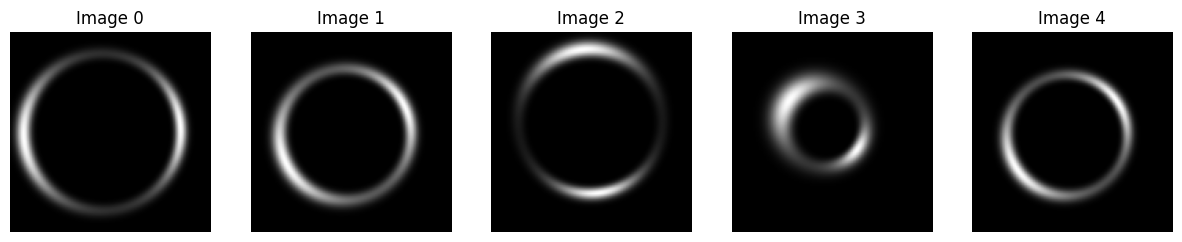

In [32]:
import os
from tqdm import tqdm
from PIL import Image
import glob

os.makedirs('simulated_lenses', exist_ok = True)

def save_image(array, filename):
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    image = (array * 255).astype(np.uint8)
    Image.fromarray(image).save(filename)

def generate_lensed_image(mass, x0, y0, sigma = 0.05, npix = 128, fov = 1.0):
    x = np.linspace(-fov / 2, fov / 2, npix)
    y = np.linspace(-fov / 2, fov / 2, npix)
    theta_x, theta_y = np.meshgrid(x, y)

    alpha_x, alpha_y = deflection_angle(theta_x, theta_y, mass)
    beta_x = theta_x - (Distance_ls / Distance_source) * alpha_x
    beta_y = theta_y - (Distance_ls / Distance_source) * alpha_y

    source_x = x
    source_y = y
    source_grid_x, source_grid_y = np.meshgrid(source_x, source_y)
    source_plane = gaussian_source(source_grid_x, source_grid_y, x0, y0, sigma)

    scale = npix / fov
    coords_x = (beta_x + fov / 2) * scale
    coords_y = (beta_y + fov / 2) * scale
    coords = np.array([coords_y.flatten(), coords_x.flatten()])
    lensed_image = map_coordinates(source_plane, coords, order = 1).reshape((npix, npix))

    return lensed_image

n_images = 500
npix = 128
fov = 1.0

for i in tqdm(range(n_images)):
    mass = np.random.uniform(0.01, 0.1)
    x0 = np.random.uniform(-0.1, 0.1)
    y0 = np.random.uniform(-0.1, 0.1)
    sigma = np.random.uniform(0.02, 0.07)

    img = generate_lensed_image(mass, x0, y0, sigma, npix, fov)
    save_image(img, f'simulated_lenses/lens_{i:04d}.png')

image_paths = sorted(glob.glob('simulated_lenses/*.png'))[:5]

plt.figure(figsize = (15, 3))
for i, path in enumerate(image_paths):
    img = Image.open(path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.title(f'Image {i}')
plt.show()